# HTTP

In [2]:
import pandas as pd
import numpy as np
import os
import regex as re
from tqdm.autonotebook import tqdm
import requests
import math
import time
import json
import xml.etree.ElementTree as ET
import io
import datetime
from dateutil import parser
from multiprocessing.dummy import Pool
import urllib3
from requests.adapters import HTTPAdapter
from datetime import datetime, timedelta

/Users/max/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
url_user_pass = {}
with open('url_user_pass.json') as json_file:
    url_user_pass = json.load(json_file)
    url_user_pass = url_user_pass.get("Data Extract Test")

In [6]:
host= url_user_pass.get("QforIT").get("tenant")

session = requests.Session()
session.auth = (url_user_pass.get("suser"), url_user_pass.get("password"))
session.mount('https://', HTTPAdapter(pool_connections=5, pool_maxsize=20))
def getCount():
    counturl = url_user_pass.get("QforIT").get("get_count")

    r = session.get(str(counturl))
    count = r.content
    bcount = int(str(count)[2:8])
    return bcount

In [7]:
def requesturl(top,skip, url):
    requesturl = url.format(top,skip)
    return requesturl

def request(top,skip, url):
    req = requesturl(top,skip, str(url))
    res = session.get(req)
    contents = res.content.decode('utf8')
    data = json.loads(contents)
    
    return data

In [17]:
def processMsg(stack, data):
    for msg in data.get('d').get('results'):
        dat = dict({
            'MessageGuid': msg.get('MessageGuid'),
            'CorrelationId': msg.get('CorrelationId'),
            'ApplicationMessageId': msg.get('ApplicationMessageId'),
            'ApplicationMessageType': msg.get('ApplicationMessageType'),
            'LogStart': convertdatetime(msg.get('LogStart')),
            'LogEnd': convertdatetime(msg.get('LogEnd')),
            'Sender': msg.get('Sender'),
            'Receiver': msg.get('Receiver'),
            'IntegrationFlowName': msg.get('IntegrationFlowName'),
            'Status': msg.get('Status'),
            'LogLevel': msg.get('LogLevel'),
            'CustomStatus': msg.get('CustomStatus'),
            'TransactionId': msg.get('TransactionId'),
            'PreviousComponentName': msg.get('PreviousComponentName') 
        })
        stack.append(dat)
    return stack

def convertdatetime(x):
    regexstring = r"\/\w{4}\((\d*?)\d{3}\)\/"
    res = re.search(regexstring, x)
    if res:
        dt = datetime.fromtimestamp(int(res.group(1))).isoformat()
        return dt
    return None
        
def download_logs(lastdate = None):
    skipamount = 1000
    
    stack = []#pd.DataFrame(columns=['MessageGuid','CorrelationId','ApplicationMessageId','ApplicationMessageType','LogStart','LogEnd','Sender','Receiver''IntegrationFlowName','Status''LogLevel','CustomStatus','TransactionId','PreviousComponentName'])
    
    url = str(url_user_pass.get("QforIT").get("download_logs_url"))
    if lastdate != None:
        url = url + "&$filter=LogEnd ge datetime%27"+lastdate[:-3]+"%27"
    data = request(skipamount,skipamount,url)
    count = data.get('d').get('__count')
    
    requestcount = math.ceil(int(count)/skipamount)
    
    pbar = tqdm(total=requestcount*skipamount, leave=False)
    pbar.set_description(desc='Downloading log entries', refresh=True)
    pbar.update(skipamount)
    for i in range(0,requestcount):
        data = request(skipamount,i*skipamount,url)
        stack = processMsg(stack, data)
        pbar.update(skipamount)
    pbar.close()
    return stack

def getMaxDate(df):
    start = df.LogStart.max()
    end = df.LogEnd.max()
    if start >= end:
        return start
    elif end > start:
        return end

def getLogs(date):
#     date = readfromfile()
    df = download_logs(date)
    df = pd.DataFrame(df, columns=['MessageGuid','CorrelationId','ApplicationMessageId','ApplicationMessageType','LogStart','LogEnd','Sender','Receiver''IntegrationFlowName','Status''LogLevel','CustomStatus','TransactionId','PreviousComponentName'])
    dfcount = df.shape[0]
    if dfcount > 0:
        newmaxdate = getMaxDate(df)
#         filename = getfilename(df)
#         writetofile(newmaxdate)
#         df.to_csv(filename)
        guids = df['MessageGuid'].unique()
        return guids, date, newmaxdate
    else:
        return [], None, None
    

# def writetofile(date):
#     with open('latestdate.txt', 'w') as file:  
#         file.write(str(date))
        
def readfromfile():
    with open('latestdate.txt', 'r') as file:  
        data = file.read() 
        return data
    
def getfilename(df):
    olddate = readfromfile()
    newdate = parser.parse(str(getMaxDate(df))).isoformat()
    filename = "logs" + str(olddate) + " to " + str(newdate) + ".csv"
    return filename


In [18]:
MSG_DETAIL_URL = url_user_pass.get("QforIT").get("msgdetailurl")

def getMessageText(guids):
    session = requests.Session()
    session.auth = (url_user_pass.get("suser"), url_user_pass.get("password"))
    
    stack = []
    
    def req_split(GUID):
        res = session.get(MSG_DETAIL_URL + GUID)
        contents = res.content.decode('utf8')
        root = ET.fromstring(contents)
        tag = (GUID, root.findtext(".//mplData"))
        
        pbar.update(1)
        stack.append(tag) 
    
    pbar = tqdm(total=len(guids), leave=False)
    pbar.set_description(desc='Downloading log entries text', refresh=True)
    
    with Pool(49) as p:
        pm = p.imap_unordered(req_split,guids)
        pm = [i for i in pm if i]
    
    pbar.close()
    return stack    

def getmsgfilename(date1,date2):
    filename = "log msg" + str(date1) + " to " + str(date2) + ".csv"
    return filename
        
def getDetails(guids, date, newmaxdate):
    stack = getMessageText(guids)
    dt = []
    count = 0
    for i in stack:
        dt.append((i))
    df = pd.DataFrame(dt, columns=['GUID','MSG'])
#     filename = getmsgfilename(date, newmaxdate)
#     df.to_csv(filename)

In [19]:
# waittime_in_sec = 60*60
# while True:
# guids, date, newmaxdate = getLogs()
# if len(guids) > 0: 
#     getDetails(guids, date, newmaxdate)
#     pbar = tqdm(total=waittime_in_sec, leave=False)
#     pbar.set_description(desc='Waiting', refresh=True)
#     for i in range(0,waittime_in_sec):
#         time.sleep(1)
#         pbar.update(1)
#     pbar.close()

In [20]:
downloadrangeinhours = [1,2,4,8,12,24,48,72,168,336,504,672]
times = []
size = []

In [21]:
def getTimeInsight(downloadrangeinhours):
    for i in downloadrangeinhours:
        date = datetime.today() - timedelta(days=1 ,hours=i, minutes=0)
        date = parser.parse(str(date))
        date = date.isoformat()
        start = time.time()
        guids, date, newmaxdate = getLogs(date)
        if len(guids) > 0: 
            getDetails(guids, date, newmaxdate)
        
        end = time.time()
        elapsed = end - start
        print(elapsed)
        print(len(guids))
        times.append(elapsed)
        size.append(len(guids))

In [22]:
downloadrangeinhours = [840]
getTimeInsight(downloadrangeinhours)
downloadrangeinhours = [1,2,4,8,12]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [28]:
df = pd.DataFrame(
    {'hours': downloadrangeinhours,
     'time': times,
     'size': size
    })

In [29]:
df['time_in_min'] = df['time']/60

In [30]:
import seaborn as sns
sns.set_style("whitegrid")

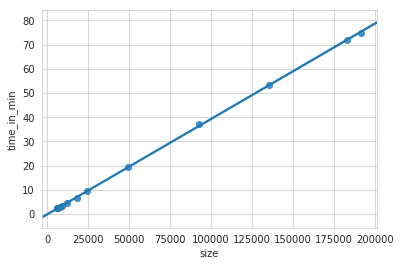

In [31]:
ax = sns.regplot(x="size", y="time_in_min", data=df)

In [35]:
from sklearn.linear_model import LinearRegression

In [42]:
X = df.drop(['time','hours','time_in_min'], axis=1).values
y = df['time_in_min'].values
reg = LinearRegression().fit(X, y)

In [53]:
month = 490000*30
pred = reg.predict([[7069924]])
pred

array([2788.02769828])

In [54]:
pred[0]/60

46.46712830465929